In [1]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.1/575.1 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/15 | LR: 0.0005 | Batch Size: 128
Train Loss: 0.5357, Train Acc: 81.56%, Train F1: 0.8151 | Val Loss: 0.3225, Val Acc: 88.85%, Val F1: 0.8897 | Test Loss: 0.3200, Test Acc: 88.88%, Test F1: 0.8900
Epoch 2/15 | LR: 0.0005 | Batch Size: 128
Train Loss: 0.2341, Train Acc: 91.97%, Train F1: 0.9196 | Val Loss: 0.2470, Val Acc: 91.38%, Val F1: 0.9135 | Test Loss: 0.2499, Test Acc: 91.35%, Test F1: 0.9131
Epoch 3/15 | LR: 0.0005 | Batch Size: 128
Train Loss: 0.1751, Train Acc: 93.97%, Train F1: 0.9397 | Val Loss: 0.2408, Val Acc: 91.87%, Val F1: 0.9181 | Test Loss: 0.2559, Test Acc: 91.18%, Test F1: 0.9108
Epoch 4/15 | LR: 0.0005 | Batch Size: 128
Train Loss: 0.1412, Train Acc: 95.11%, Train F1: 0.9511 | Val Loss: 0.2354, Val Acc: 92.60%, Val F1: 0.9262 | Test Loss: 0.2317, Test Acc: 92.39%, Test F1: 0.9240
Epoch 5/15 | LR: 0.0005 | Batch Size: 128
Train Loss: 0.1225, Train Acc: 95.71%, Train F1: 0.9571 | Val Loss: 0.2725, Val Acc: 90.93%, Val F1: 0.9101 | Test Loss: 0.2876, Test Acc:

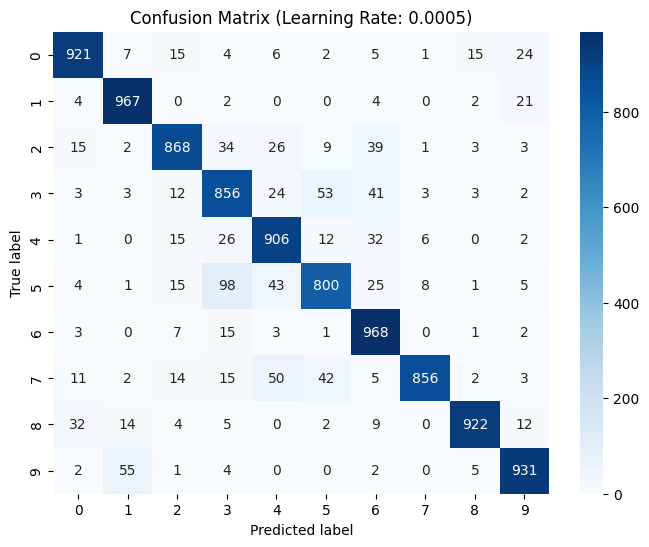

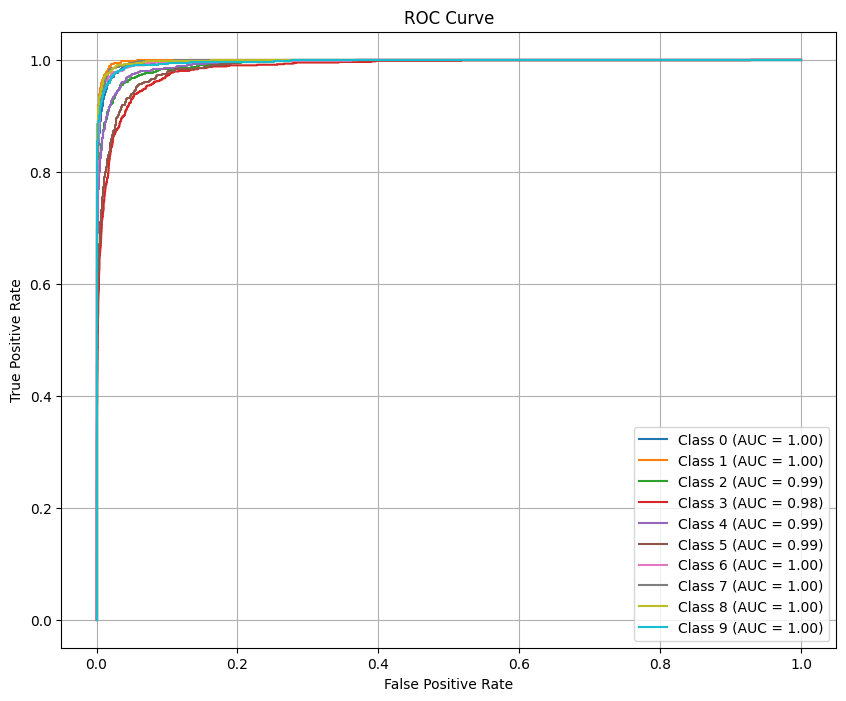

2024/12/10 18:11:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/10 18:11:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from timm import create_model
import mlflow
import mlflow.pytorch
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Vision Transformer Model
class TinyViT(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyViT, self).__init__()
        self.vit = create_model('deit_tiny_patch16_224', pretrained=True)
        self.vit.head = nn.Linear(self.vit.embed_dim, num_classes)

    def forward(self, x):
        return self.vit(x)

# Data Augmentation and Data Loading
def load_data(batch_size):
    augmentations = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = datasets.CIFAR10(root='./data', train=True, transform=augmentations, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=augmentations, download=True)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / len(train_loader.dataset)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return total_loss / len(train_loader), accuracy, f1

# Evaluate the model
def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = 100 * correct / len(loader.dataset)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)
    return total_loss / len(loader), accuracy, f1, cm, all_labels, all_probs

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# Plot ROC Curve
def plot_roc_curve(y_true, y_probs, num_classes=10):
    y_true_onehot = np.eye(num_classes)[y_true]
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], np.array(y_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Main function with hyperparameter tuning and MLflow
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    learning_rates = [0.0005]
    batch_sizes = [128]
    num_epochs_list = [15]

    for lr in learning_rates:
        for batch_size in batch_sizes:
            for num_epochs in num_epochs_list:
                train_loader, val_loader, test_loader = load_data(batch_size)
                model = TinyViT(num_classes=10).to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                with mlflow.start_run():
                    mlflow.log_param("learning_rate", lr)
                    mlflow.log_param("batch_size", batch_size)
                    mlflow.log_param("num_epochs", num_epochs)

                    for epoch in range(num_epochs):
                        print(f"Epoch {epoch + 1}/{num_epochs} | LR: {lr} | Batch Size: {batch_size}")

                        # Training Phase
                        train_loss, train_acc, train_f1 = train_model(model, train_loader, criterion, optimizer, device)

                        # Validation Phase
                        val_loss, val_acc, val_f1, _, _, _ = evaluate_model(model, val_loader, criterion, device)

                        # Test Phase (after each epoch)
                        test_loss, test_acc, test_f1, cm, all_labels, all_probs = evaluate_model(model, test_loader, criterion, device)

                        # Logging to MLflow
                        mlflow.log_metric("train_loss", train_loss, step=epoch)
                        mlflow.log_metric("train_acc", train_acc, step=epoch)
                        mlflow.log_metric("train_f1", train_f1, step=epoch)
                        mlflow.log_metric("val_loss", val_loss, step=epoch)
                        mlflow.log_metric("val_acc", val_acc, step=epoch)
                        mlflow.log_metric("val_f1", val_f1, step=epoch)
                        mlflow.log_metric("test_loss", test_loss, step=epoch)
                        mlflow.log_metric("test_acc", test_acc, step=epoch)
                        mlflow.log_metric("test_f1", test_f1, step=epoch)

                        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f} | "
                              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f} | "
                              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.4f}")

                    # Plot Confusion Matrix (after final test)
                    plot_confusion_matrix(cm, classes=list(range(10)), title=f"Confusion Matrix (Learning Rate: {lr})")

                    # Plot ROC Curve (after final test)
                    plot_roc_curve(all_labels, all_probs)

                    # Log the model to MLflow
                    mlflow.pytorch.log_model(model, "tiny_vit_model")

if __name__ == "__main__":
    main()


In [4]:
!zip -r mlruns_128_5.zip mlruns
from google.colab import files
files.download('mlruns_128_5.zip')

  adding: mlruns/ (stored 0%)
  adding: mlruns/0/ (stored 0%)
  adding: mlruns/0/b600fc12f61840e2b8ef6f36bdfa84cc/ (stored 0%)
  adding: mlruns/0/b600fc12f61840e2b8ef6f36bdfa84cc/artifacts/ (stored 0%)
  adding: mlruns/0/b600fc12f61840e2b8ef6f36bdfa84cc/artifacts/tiny_vit_model/ (stored 0%)
  adding: mlruns/0/b600fc12f61840e2b8ef6f36bdfa84cc/artifacts/tiny_vit_model/data/ (stored 0%)
  adding: mlruns/0/b600fc12f61840e2b8ef6f36bdfa84cc/artifacts/tiny_vit_model/data/pickle_module_info.txt (stored 0%)
  adding: mlruns/0/b600fc12f61840e2b8ef6f36bdfa84cc/artifacts/tiny_vit_model/data/model.pth (deflated 7%)
  adding: mlruns/0/b600fc12f61840e2b8ef6f36bdfa84cc/artifacts/tiny_vit_model/python_env.yaml (deflated 18%)
  adding: mlruns/0/b600fc12f61840e2b8ef6f36bdfa84cc/artifacts/tiny_vit_model/requirements.txt (deflated 54%)
  adding: mlruns/0/b600fc12f61840e2b8ef6f36bdfa84cc/artifacts/tiny_vit_model/MLmodel (deflated 44%)
  adding: mlruns/0/b600fc12f61840e2b8ef6f36bdfa84cc/artifacts/tiny_vit_mo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>